# Fitting PRFs in K2 Campaign 11.1

In [1]:
%matplotlib inline
from astropy.io import fits as pyfits
import tqdm
import numpy as np
import matplotlib.pyplot as pl
import photutils.aperture as apr

Let's import the classes we will need from [PyKE](https://pyke.keplerscience.org) and [oktopus](https://keplergo.github.io/oktopus):

In [2]:
from pyke import KeplerTargetPixelFile, KeplerQualityFlags
from oktopus import PoissonPosterior, UniformPrior
from pyke.kepler_prf import KeplerPRF

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 18,
        'serif'  : 'New Century Schoolbook'}
rc('font', **font)

Let's load our target using the KeplerTargetPixelFile class and let's plot [photutils](https://github.com/photutils) apertures around each star:

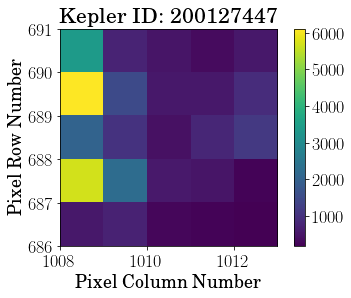

In [4]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c111/200100000/27000/ktwo200127447-c111_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.QUALITY_ZERO_BITMASK)
tpf.plot(scale='linear', nframe=20)
pl.savefig("tpf.png")

The messy part below (which will soon be encapsulated as a class called `KeplerPRFPhotometry`) iterates over all frames of the target pixel file, solving an optimization problem for every frame, and storing the results of the optmization in the arrays declared below.

In [5]:
xc1_hat, xc2_hat, xc3_hat = [], [], []
yc1_hat, yc2_hat, yc3_hat = [], [], []
f1_hat, f2_hat, f3_hat = [], [], []
bkg_hat = []
fitted_img = []
loglike = []
prf1, prf2, prf3 = [], [], []
kepprf = KeplerPRF(tpf.channel, (tpf.shape[1], tpf.shape[2]),
                   tpf.column, tpf.row,
                   prf_files_dir="/Users/jvmirca/.pyke/kepler-prf-calibration-data/")

prior = UniformPrior(lb=[7000, 14000, 2500, 1008.7, 1008, 1011, 687.7, 689.9, 688.8, 200],
                     ub=[18000, 20000, 3400, 1008.9, 1009, 1013, 688, 690.2, 689.4, 400])

for i in tqdm.tqdm(range(len(tpf.time))):
    # vector of initial guesses (these values were estimated by using the MLE solution)
    x0 = np.array((12000, # Flux for first source
                   17000, # Flux for second source
                   3200,         # Flux for the third source
                   1008.8, 1008.5, 1012,  # Column centroid for first, second, and third sources
                   687.9, 690, 689.1,     # Row centroid for first, second, and third sources
                   300))                 # Background
    logL = PoissonPosterior(tpf.flux[i], kepprf.evaluate, prior=prior)
    result = logL.fit(x0, method='Powell')
    f1_hat = np.append(f1_hat, result.x[0])
    f2_hat = np.append(f2_hat, result.x[1])
    f3_hat = np.append(f3_hat, result.x[2])
    xc1_hat = np.append(xc1_hat, result.x[3])
    xc2_hat = np.append(xc2_hat, result.x[4])
    xc3_hat = np.append(xc3_hat, result.x[5])
    yc1_hat = np.append(yc1_hat, result.x[6])
    yc2_hat = np.append(yc2_hat, result.x[7])
    yc3_hat = np.append(yc3_hat, result.x[8])
    bkg_hat = np.append(bkg_hat, result.x[9])
    prf1 = np.append(prf1, kepprf.prf_model[0])
    prf2 = np.append(prf2, kepprf.prf_model[1])
    prf3 = np.append(prf3, kepprf.prf_model[2])
    fitted_img = np.append(fitted_img, kepprf.evaluate(*result.x))

  0%|          | 0/1038 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
100%|██████████| 1038/1038 [08:11<00:00,  1.68it/s]


(9055.446930406195, 17226.903707518188)

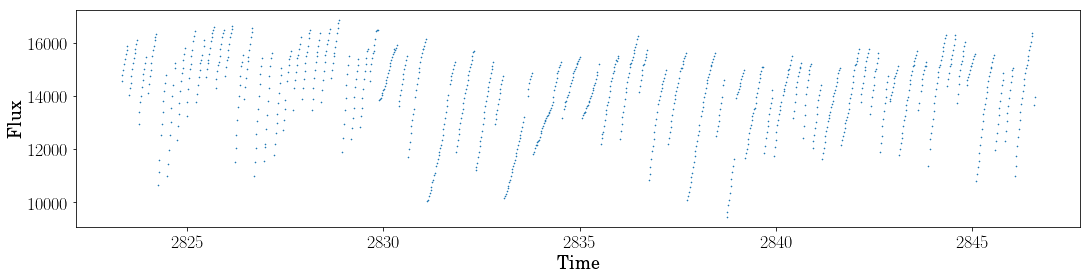

In [6]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, f1_hat, 'x', markersize=1)
pl.ylabel("Flux")
pl.xlabel("Time")
pl.ylim()

(15179.945632436444, 18002.641717857434)

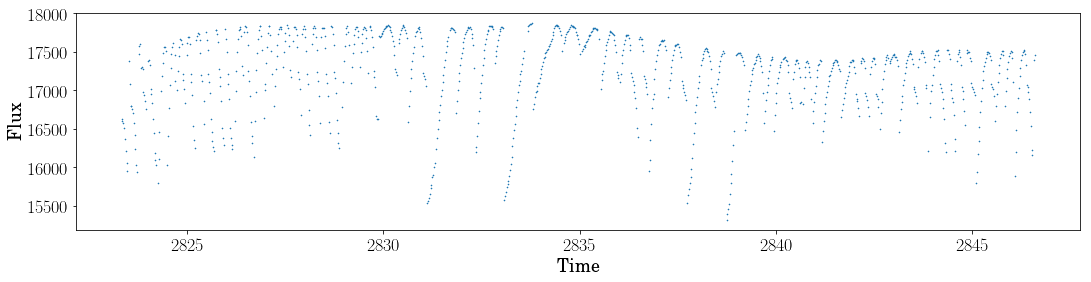

In [7]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, f2_hat, 'x', markersize=1)
pl.ylabel("Flux")
pl.xlabel("Time")
pl.ylim()

(2840.2234487609312, 3381.3891261336098)

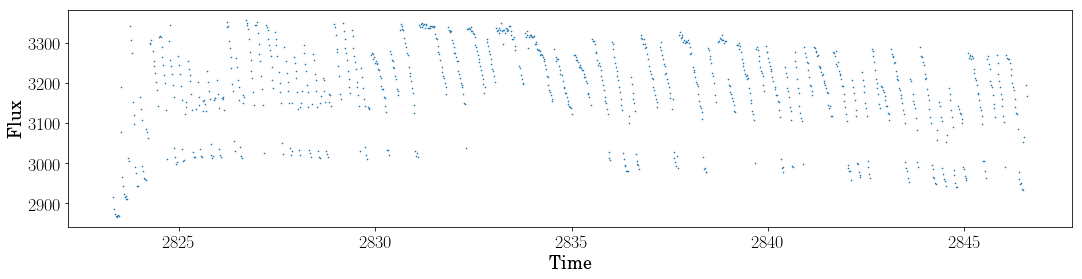

In [8]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, f3_hat, 'x', markersize=1)
pl.ylabel("Flux")
pl.xlabel("Time")
pl.ylim()

In [9]:
fitted_img = fitted_img.reshape(tpf.shape)
residuals = tpf.flux - fitted_img

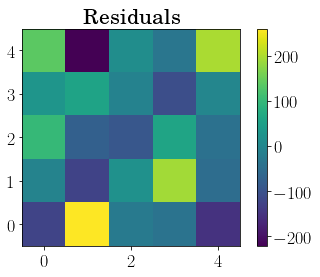

In [10]:
pl.imshow(residuals[20], origin='lower')
pl.colorbar()
pl.title("Residuals")
pl.savefig("residual.png")

(-49.186557712102513, 334.36960984660044)

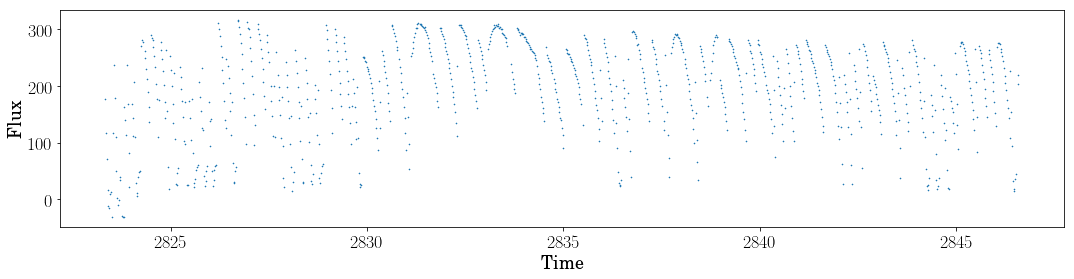

In [11]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, residuals.sum(axis=(1, 2)), 'x', markersize=1)
pl.ylabel("Flux")
pl.xlabel("Time")
pl.ylim()

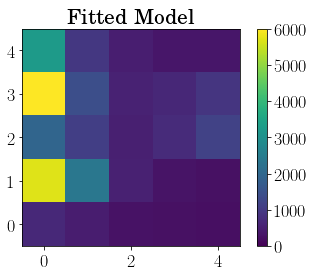

In [12]:
pl.imshow(fitted_img[20], origin='lower', vmin=0, vmax=6000)
pl.colorbar()
pl.title("Fitted Model")
pl.savefig("fitted_model.png")

In [13]:
prf1 = np.array(prf1).reshape(tpf.shape)
prf2 = np.array(prf2).reshape(tpf.shape)
prf3 = np.array(prf3).reshape(tpf.shape)

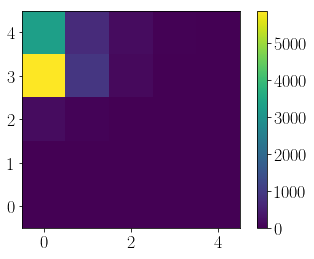

In [14]:
pl.imshow(prf2[-1], origin='lower')
pl.colorbar()

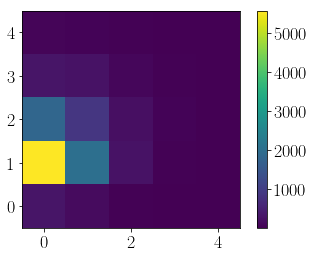

In [15]:
pl.imshow(prf1[-1], origin='lower')
pl.colorbar()

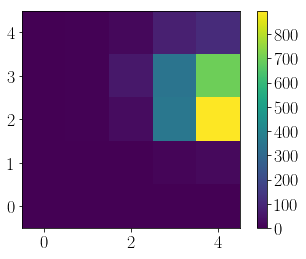

In [16]:
pl.imshow(prf3[-1], origin='lower')
pl.colorbar()

(233.76518390013399, 317.2138280865492)

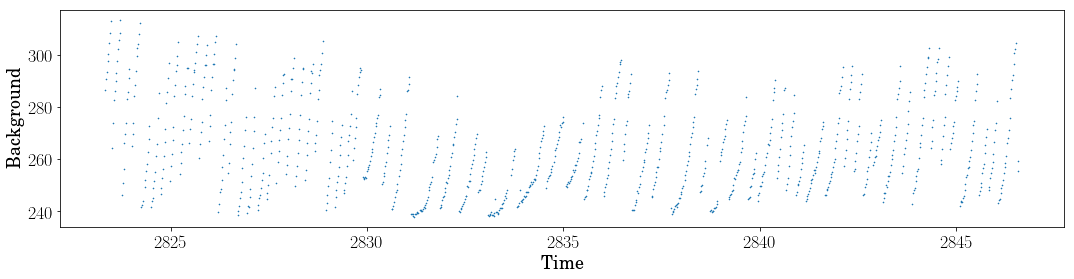

In [17]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, bkg_hat, 'x', markersize=1)
pl.ylabel("Background")
pl.xlabel("Time")
pl.ylim()